In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_fix import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle, arcosh
from torch import autograd
torch.manual_seed(42)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

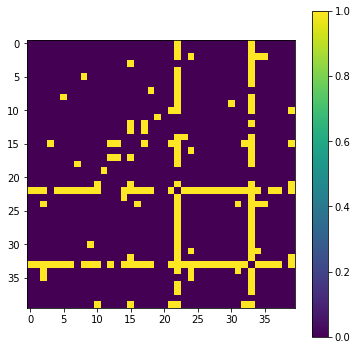

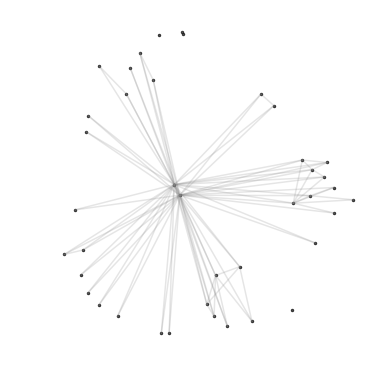

In [18]:
N = 40
R = torch.tensor([10.0]).double()
alpha = .55
T = 0.01

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [25]:
W = G.generate_W(1000)

KeyboardInterrupt: 

In [ ]:
W.max(), W.min()

In [21]:
log1pexp = lambda a: torch.where(a>torch.tensor(18.).to(a.dtype),
                                 torch.where(a>torch.tensor(33.3).to(a.dtype),
                                             a,
                                             a + (-a).exp()),
                                 torch.where(a>torch.tensor(-37.).to(a.dtype),
                                             a.exp().log1p(),
                                             a.exp()))

In [23]:
log1pexp_ = lambda a: torch.where(a>torch.tensor(18.).to(a.dtype),
                                 torch.where(a>torch.tensor(33.3).to(a.dtype),
                                             torch.zeros(a.size()),
                                             -(-a).exp()),
                                 torch.where(a>torch.tensor(-37.).to(a.dtype),
                                             a - a.exp().log1p(),
                                             a - a.exp()))

In [24]:
a = torch.arange(-50., 50., .5)
log1pexp_(a)

tensor([-5.0000e+01, -4.9500e+01, -4.9000e+01, -4.8500e+01, -4.8000e+01,
        -4.7500e+01, -4.7000e+01, -4.6500e+01, -4.6000e+01, -4.5500e+01,
        -4.5000e+01, -4.4500e+01, -4.4000e+01, -4.3500e+01, -4.3000e+01,
        -4.2500e+01, -4.2000e+01, -4.1500e+01, -4.1000e+01, -4.0500e+01,
        -4.0000e+01, -3.9500e+01, -3.9000e+01, -3.8500e+01, -3.8000e+01,
        -3.7500e+01, -3.7000e+01, -3.6500e+01, -3.6000e+01, -3.5500e+01,
        -3.5000e+01, -3.4500e+01, -3.4000e+01, -3.3500e+01, -3.3000e+01,
        -3.2500e+01, -3.2000e+01, -3.1500e+01, -3.1000e+01, -3.0500e+01,
        -3.0000e+01, -2.9500e+01, -2.9000e+01, -2.8500e+01, -2.8000e+01,
        -2.7500e+01, -2.7000e+01, -2.6500e+01, -2.6000e+01, -2.5500e+01,
        -2.5000e+01, -2.4500e+01, -2.4000e+01, -2.3500e+01, -2.3000e+01,
        -2.2500e+01, -2.2000e+01, -2.1500e+01, -2.1000e+01, -2.0500e+01,
        -2.0000e+01, -1.9500e+01, -1.9000e+01, -1.8500e+01, -1.8000e+01,
        -1.7500e+01, -1.7000e+01, -1.6500e+01, -1.6

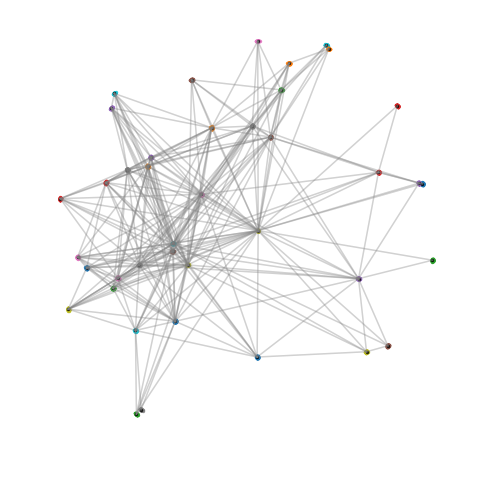

Likelihood: -677.4469212089784


In [79]:
r_loc_init = logit(r/R)
r_scale_init = (torch.ones([N]).double()/100).log()
phi_loc_init = polar2cart(1, theta)
phi_scale_init = (torch.ones([N]).double()*100000).log()
dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
vi = VI_HRG(N,20, init_values={
                                      'rs_loc':r_loc_init,
                                      'rs_scale':r_scale_init,
                                      'phis_loc':phi_loc_init,
                                      'phis_scale':phi_scale_init, 
                                      'R_conc':None, 
                                      'R_scale':None,
                                      'alpha_conc':None,
                                      'alpha_scale':None,
                                      'T':None},
                   fixed={'R':R, 
                          'T':T,
                          'alpha':alpha},
                   priors={'R_p':torch.tensor([20., 0.4]), 
                            'T_p':torch.tensor([1., 15.]),
                            'alpha_p':torch.tensor([27., 0.03])},)
vi.dataloader = dataloader
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
for link in A.nonzero():
    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R.item()*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi.likelihood())

In [105]:
Ts = torch.arange(0.01, 1., 0.01)
lh_T = []
trials = 3
for t in Ts:
    acc = 0
    for i in range(trials):
        r_loc_init = logit(r/R)
        r_scale_init = (torch.ones([N]).double()/100).log()
        phi_loc_init = polar2cart(1, theta)
        phi_scale_init = (torch.ones([N]).double()*100000).log()
        dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
        vi = VI_HRG(N,20, init_values={
                                              'rs_loc':r_loc_init,
                                              'rs_scale':r_scale_init,
                                              'phis_loc':phi_loc_init,
                                              'phis_scale':phi_scale_init, 
                                              'R_conc':None, 
                                              'R_scale':None,
                                              'alpha_conc':None,
                                              'alpha_scale':None,
                                              'T':None},
                           fixed={'R':R, 
                                  'T':t,
                                  'alpha':alpha},
                           priors={'R_p':torch.tensor([20., 0.4]), 
                                    'T_p':torch.tensor([1., 15.]),
                                    'alpha_p':torch.tensor([27., 0.03])},)
        vi.dataloader = dataloader
        acc += vi.likelihood()
    lh_T.append(acc/trials)

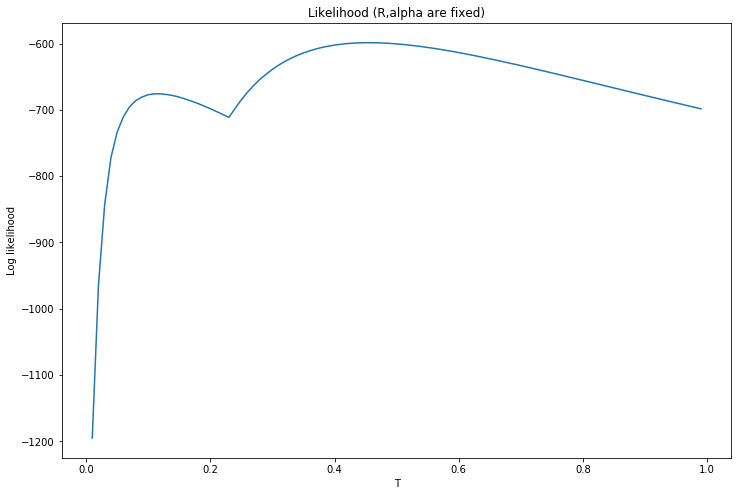

In [109]:
plt.figure(figsize=(12,8))
plt.plot(Ts.numpy(), np.array(lh_T))
plt.title('Likelihood (R,alpha are fixed)')
plt.xlabel('T')
plt.ylabel('Log likelihood')
plt.show()

In [115]:
Rs = torch.arange(.1, 10., .1)
lh_R = []
trials = 3
for x in Rs:
    acc = 0
    for i in range(trials):
        r_loc_init = logit(r/R)
        r_scale_init = (torch.ones([N]).double()/100).log()
        phi_loc_init = polar2cart(1, theta)
        phi_scale_init = (torch.ones([N]).double()*100000).log()
        dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
        vi = VI_HRG(N,20, init_values={
                                              'rs_loc':r_loc_init,
                                              'rs_scale':r_scale_init,
                                              'phis_loc':phi_loc_init,
                                              'phis_scale':phi_scale_init, 
                                              'R_conc':None, 
                                              'R_scale':None,
                                              'alpha_conc':None,
                                              'alpha_scale':None,
                                              'T':None},
                           fixed={'R':x, 
                                  'T':T,
                                  'alpha':alpha},
                           priors={'R_p':torch.tensor([20., 0.4]), 
                                    'T_p':torch.tensor([1., 15.]),
                                    'alpha_p':torch.tensor([27., 0.03])},)
        vi.dataloader = dataloader
        acc += vi.likelihood()
    lh_R.append(acc/trials)

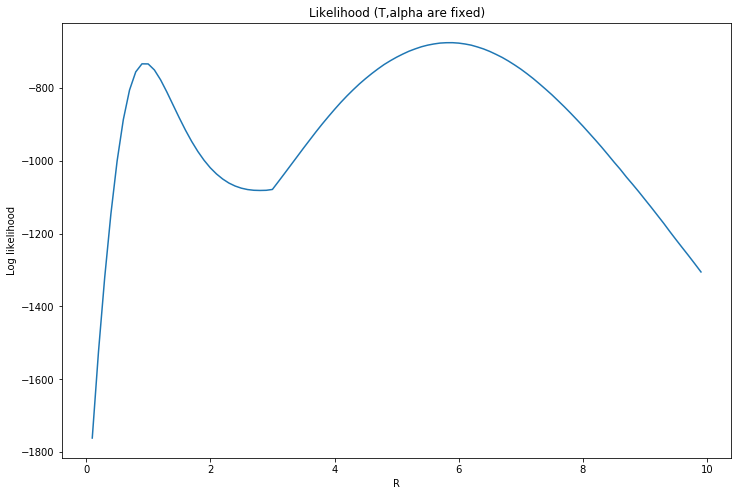

In [116]:
plt.figure(figsize=(12,8))
plt.plot(Rs.numpy(), np.array(lh_R))
plt.title('Likelihood (T,alpha are fixed)')
plt.xlabel('R')
plt.ylabel('Log likelihood')
plt.show()

In [120]:
alphas = torch.arange(.02, 1., .02)
lh_a = []
trials = 3
for x in alphas:
    acc = 0
    for i in range(trials):
        r_loc_init = logit(r/R)
        r_scale_init = (torch.ones([N]).double()/100).log()
        phi_loc_init = polar2cart(1, theta)
        phi_scale_init = (torch.ones([N]).double()*100000).log()
        dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
        vi = VI_HRG(N,20, init_values={
                                              'rs_loc':r_loc_init,
                                              'rs_scale':r_scale_init,
                                              'phis_loc':phi_loc_init,
                                              'phis_scale':phi_scale_init, 
                                              'R_conc':None, 
                                              'R_scale':None,
                                              'alpha_conc':None,
                                              'alpha_scale':None,
                                              'T':None},
                           fixed={'R':R, 
                                  'T':T,
                                  'alpha':x},
                           priors={'R_p':torch.tensor([20., 0.4]), 
                                    'T_p':torch.tensor([1., 15.]),
                                    'alpha_p':torch.tensor([27., 0.03])},)
        vi.dataloader = dataloader
        acc += vi.likelihood()
    lh_a.append(acc/trials)

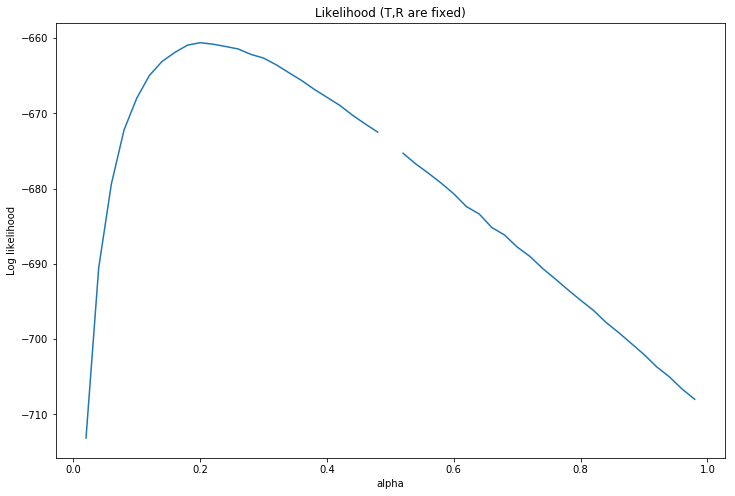

In [121]:
plt.figure(figsize=(12,8))
plt.plot(alphas.numpy(), np.array(lh_a))
plt.title('Likelihood (T,R are fixed)')
plt.xlabel('alpha')
plt.ylabel('Log likelihood')
plt.show()

In [126]:
r_loc_init = logit(r/R)
r_scale_init = (torch.ones([N]).double()/100).log()
phi_loc_init = polar2cart(1, theta)
phi_scale_init = (torch.ones([N]).double()*100000).log()
dataloader = DataLoader(EdgesDataset(A), batch_size=int(N), shuffle=True, num_workers=0)
vi = VI_HRG(N,20, init_values={
                                      'rs_loc':r_loc_init,
                                      'rs_scale':r_scale_init,
                                      'phis_loc':phi_loc_init,
                                      'phis_scale':phi_scale_init, 
                                      'R_conc':None, 
                                      'R_scale':None,
                                      'alpha_conc':None,
                                      'alpha_scale':None,
                                      'T':None},
                   fixed={'R':R, 
                          'T':T,
                          'alpha':.2},
                   priors={'R_p':torch.tensor([20., 0.4]), 
                            'T_p':torch.tensor([1., 15.]),
                            'alpha_p':torch.tensor([27., 0.03])},)
vi.dataloader = dataloader
print('Likelihood:', vi.likelihood())

Likelihood: -660.8120483728065
